# Evaluating a classification model


## Classification accuracy



In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

pd.options.display.max_rows = 999

In [2]:
# Read in data and split data to be used in the models
titanic = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/nyc-mhtn-ds-042219-lectures/master/Module_4/cleaned_titanic.csv', index_col='PassengerId')



In [3]:
titanic['youngin'] = titanic['Age']<=9

In [4]:
# Create matrix of features
X = titanic.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = titanic['Survived'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

In [5]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,youngin,male,Q,S
PassengerId,,,,,,,,,
1,3,22.0,1,0,7.2500,False,1,0,1
2,1,38.0,1,0,71.2833,False,0,0,0
3,3,26.0,0,0,7.9250,False,0,0,1
4,1,35.0,1,0,53.1000,False,0,0,1
5,3,35.0,0,0,8.0500,False,1,0,1


In [6]:
# Use x and y variables to split the training data into train and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [8]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
dictionary = dict(zip(list(X.columns), list(logreg.coef_[0])))

In [10]:
dictionary

{'Pclass': -0.8301630306334177,
 'Age': -0.27232750442510445,
 'SibSp': -0.41352380252254584,
 'Parch': -0.136032637628296,
 'Fare': 0.10004948054909828,
 'youngin': 0.4832255531794577,
 'male': -1.1908477761605316,
 'Q': -0.05431278752275039,
 'S': -0.2694610619613225}

### What insights can we derive from these coefficients?

On slack, send me a DM with one interpretations/insight you can take from these coefficients.

In [11]:
# make class predictions for the testing set
preds = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [12]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, preds))

0.8251121076233184


In [13]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.6188340807174888

In [14]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.825112
recall,0.752941
precision,0.780488
F1,0.766467


In [15]:
THRESHOLD = 0.75
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.798206
recall,0.494118
precision,0.954545
F1,0.651163


### Precision and Recall: A Tug of War
To fully evaluate the effectiveness of a model, you must examine both precision and recall. Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa. Explore this notion by looking at the following figure.

<img src='images/PrecisionVsRecallBase.svg' width=900/>

In order to map a logistic regression value to a binary category, you must define a classification threshold (also called the decision threshold). A value above that threshold indicates "spam"; a value below indicates "not spam." It is tempting to assume that the classification threshold should always be 0.5, but thresholds are problem-dependent, and are therefore values that you must tune.


"Tuning" a threshold for logistic regression is different from tuning hyperparameters such as learning rate

Those to the right of the classification threshold are classified as "spam", while those to the left are classified as "not spam."

## ROC Curves and Area Under the Curve (AUC)

**Question:** Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

**Answer:** Plot the ROC curve!

## ROC curve
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

**True Positive Rate (TPR)** is a synonym for recall and is therefore defined as follows:

$$TPR = \frac{TP} {TP + FN}$$

**False Positive Rate (FPR)** is defined as follows:


$$FPR = \frac{FP} {FP + TN}$$


![alt text](images/perfectImbalance.png)

![alt text](images/perfectbalanceAUC.png)

![alt text](images/overlapimbalance.png)

![alt text](images/imbalancedROC.png)

## AUC: Area Under the ROC Curve
**AUC** stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

![alt text](images/perfectimbalanced.png)

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions:



In [16]:
# getting the probability predicitons
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

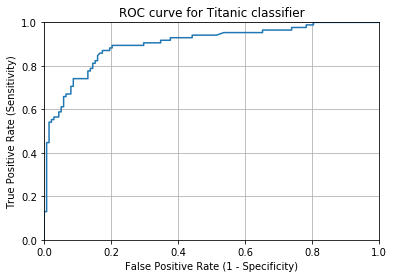

In [17]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [18]:
fpr

array([0.        , 0.        , 0.        , 0.00724638, 0.00724638,
       0.01449275, 0.01449275, 0.02173913, 0.02173913, 0.02898551,
       0.02898551, 0.04347826, 0.04347826, 0.05072464, 0.05072464,
       0.05797101, 0.05797101, 0.06521739, 0.06521739, 0.07971014,
       0.07971014, 0.08695652, 0.08695652, 0.13043478, 0.13043478,
       0.13768116, 0.13768116, 0.14492754, 0.14492754, 0.15217391,
       0.15217391, 0.15942029, 0.15942029, 0.16666667, 0.17391304,
       0.17391304, 0.19565217, 0.19565217, 0.20289855, 0.20289855,
       0.2826087 , 0.29710145, 0.29710145, 0.34782609, 0.34782609,
       0.37681159, 0.37681159, 0.44202899, 0.44202899, 0.45652174,
       0.51449275, 0.53623188, 0.60869565, 0.62318841, 0.65217391,
       0.65217391, 0.67391304, 0.70289855, 0.73913043, 0.73913043,
       0.77536232, 0.7826087 , 0.7826087 , 0.80434783, 0.80434783,
       1.        ])

In [19]:
pd.DataFrame([fpr,tpr], index=['FPR','TPR'], columns = thresholds).T.sort_index()


,FPR,TPR
0.016345,1.000000,1.000000
0.100925,0.804348,1.000000
0.102601,0.804348,0.988235
0.104609,0.782609,0.988235
0.104614,0.782609,0.976471
0.104673,0.775362,0.976471
0.104688,0.739130,0.976471
0.106202,0.739130,0.964706
0.108540,0.702899,0.964706
0.110472,0.673913,0.964706


- ROC curve can help you to **choose a threshold** that balances sensitivity and specificity in a way that makes sense for your particular context
- You can't actually **see the thresholds** used to generate the curve on the ROC curve itself

In [20]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [21]:
evaluate_threshold(0.5)

Sensitivity: 0.7411764705882353
Specificity: 0.8695652173913043


In [22]:
evaluate_threshold(0.3)

Sensitivity: 0.8941176470588236
Specificity: 0.7971014492753623


AUC is the **percentage** of the ROC plot that is **underneath the curve**:

In [23]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.9018755328218244


- AUC is useful as a **single number summary** of classifier performance.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation.
- AUC is useful even when there is **high class imbalance** (unlike classification accuracy).

In [24]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.8554268171915231

### Will regularization get us a better model?

In [34]:
# Instantiate a new LogisticRegression object using regrularization
logreg = LogisticRegression(penalty= 'elasticnet', C= .5, l1_ratio = .5, solver = 'saga' )

#fit that new model to the training data
logreg.fit(X_train, y_train)

#use that new model to create predictions on the test data
y_pred = logreg.predict(X_test)

In [37]:
# see if the model has a better AUC score than the unregularized model

print(metrics.roc_auc_score(y_test, y_pred))

0.8112531969309463


## Summary

AUC represents the probability that a random positive (green) example is positioned to the right of a random negative (red) example.

AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

AUC is desirable for the following two reasons:

- AUC is **scale-invariant**. It measures how well predictions are ranked, rather than their absolute values.
- AUC is **classification-threshold-invariant**. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.






### Two Caveats

Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.

**Confusion matrix advantages:**

- Allows you to calculate a **variety of metrics**
- Useful for **multi-class problems** (more than two response classes)

**ROC/AUC advantages:**

- Does not require you to **set a classification threshold**
- Still useful when there is **high class imbalance**

## Confusion Matrix Resources

- Blog post: [Simple guide to confusion matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by me
- Videos: [Intuitive sensitivity and specificity](https://www.youtube.com/watch?v=U4_3fditnWg) (9 minutes) and [The tradeoff between sensitivity and specificity](https://www.youtube.com/watch?v=vtYDyGGeQyo) (13 minutes) by Rahul Patwari
- Notebook: [How to calculate "expected value"](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb) from a confusion matrix by treating it as a cost-benefit matrix (by Ed Podojil)
- Graphic: How [classification threshold](https://media.amazonwebservices.com/blog/2015/ml_adjust_model_1.png) affects different evaluation metrics (from a [blog post](https://aws.amazon.com/blogs/aws/amazon-machine-learning-make-data-driven-decisions-at-scale/) about Amazon Machine Learning)


## ROC and AUC Resources

- Video: [ROC Curves and Area Under the Curve](https://www.youtube.com/watch?v=OAl6eAyP-yo) (14 minutes) by Kevin Markham, including [transcript and screenshots](http://www.dataschool.io/roc-curves-and-auc-explained/) and a [visualization](http://www.navan.name/roc/)
- Video: [ROC Curves](https://www.youtube.com/watch?v=21Igj5Pr6u4) (12 minutes) by Rahul Patwari
- Paper: [An introduction to ROC analysis](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf) by Tom Fawcett
- Usage examples: [Comparing different feature sets](http://research.microsoft.com/pubs/205472/aisec10-leontjeva.pdf) for detecting fraudulent Skype users, and [comparing different classifiers](http://www.cse.ust.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf) on a number of popular datasets


## Other Resources

- scikit-learn documentation: [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- Guide: [Comparing model evaluation procedures and metrics](https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md) by me
- Video: [Counterfactual evaluation of machine learning models](https://www.youtube.com/watch?v=QWCSxAKR-h0) (45 minutes) about how Stripe evaluates its fraud detection model, including [slides](http://www.slideshare.net/MichaelManapat/counterfactual-evaluation-of-machine-learning-models)